In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
import seaborn as sns
import textwrap
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Load and merge clinical and preclinical data
clinical_LLM_df= pd.read_csv("Clinical_Students_LLM_perspectives_data.csv")
preclinical_LLM_df = pd.read_csv("Preclinical_Students_LLM_perspectives_data.csv")
merged_LLM_df = pd.merge(clinical_LLM_df, preclinical_LLM_df, how = 'outer', on="Response")
merged_LLM_df.columns


Index(['Column_x', 'Response', 'Count_x', 'Total Responses_x', 'Percentage_x',
       'Column_y', 'Count_y', 'Total Responses_y', 'Percentage_y'],
      dtype='object')

In [3]:
# DF Pre-processing
merged_clean = merged_LLM_df.drop(['Count_x','Total Responses_x', 'Column_y','Count_y', 'Total Responses_y'],
                                  axis=1, inplace=False)

merged_clean.columns = ['Question', 'Response', 'Clinical', 'Pre-clinical']
for col in ["Clinical", "Pre-clinical"]:
    merged_clean[col] = merged_clean[col].str.rstrip("%")   
    merged_clean[col] = pd.to_numeric(merged_clean[col])   

In [4]:
# Frequency LLM
merged_LLM_freq = merged_clean.iloc[0:4, 1:4]

# Reordering for plot
order = ["A few times/rarely", "Daily", "Weekly", "Monthly"]
merged_LLM_freq["Response"] = pd.Categorical(merged_LLM_freq["Response"], categories=order, ordered=True)
merged_LLM_freq = merged_LLM_freq.sort_values("Response")

In [5]:
# Frequency Analysis (Chi-Square)

freq_data = merged_LLM_freq.drop(columns=['Response'])  
freq_data = freq_data.to_numpy()
print(freq_data)

# Chi Square Test
chi2, p, dof, expected = chi2_contingency(freq_data)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

[[ 7.69 21.05]
 [17.31 15.79]
 [34.62 26.32]
 [17.31 10.53]]
Chi-Square Statistic: 8.996381612774652
P-Value: 0.02933903366933771
Degrees of Freedom: 3


In [6]:
# Pairwise Comparisons (Bonferroni correction)
samplesize = np.array([52, 38]) # Clinical = 52, preclinical = 38
alpha = 0.05
categories = merged_LLM_freq['Response'].tolist()
num_tests = len(categories)
alpha_adjusted = alpha / num_tests
print(f"Adjusted alpha for Bonferroni correction: {alpha_adjusted:.4f}\n")

p_value_results = {}

for i, category in enumerate(categories):
    counts = freq_data[i]
    stat, p_value = proportions_ztest(counts, samplesize)
    p_value_results[category] = p_value
    print(f"Category: {category}")
    print(f"  Z-Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
    if p_value < alpha_adjusted:
        print(f"  ** Significant difference (p < {alpha_adjusted:.4f}) **")
    else:
        print(f"  Not significant\n")

p_value_df = pd.DataFrame(list(p_value_results.items()), columns = ['Category', 'pvalue'])

Adjusted alpha for Bonferroni correction: 0.0125

Category: A few times/rarely
  Z-Statistic: -4.0811, P-Value: 0.0000
  ** Significant difference (p < 0.0125) **
Category: Daily
  Z-Statistic: -0.8031, P-Value: 0.4219
  Not significant

Category: Weekly
  Z-Statistic: -0.2692, P-Value: 0.7878
  Not significant

Category: Monthly
  Z-Statistic: 0.5655, P-Value: 0.5718
  Not significant



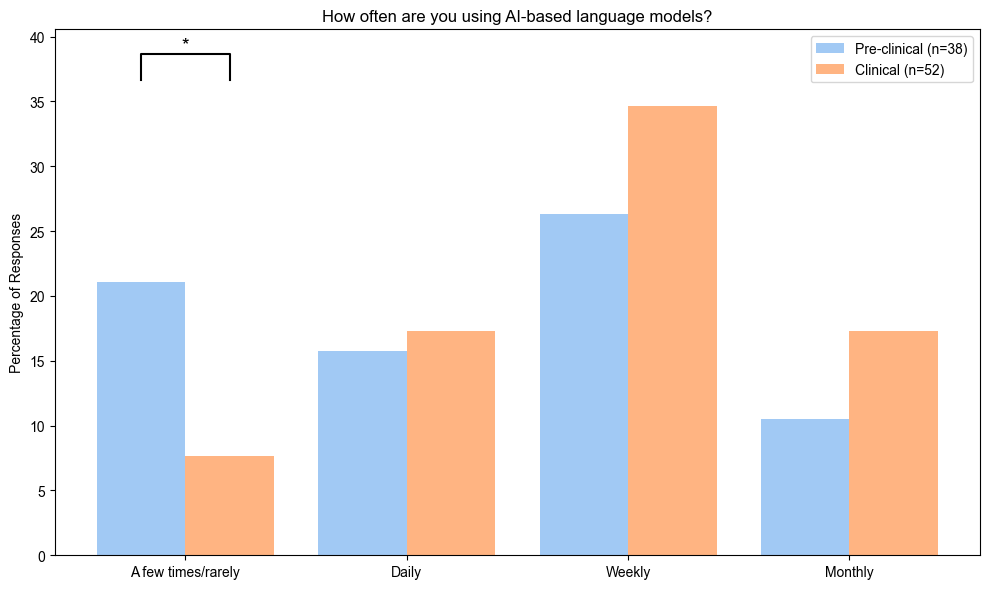

In [7]:
# Plot LLM Freq 
sns.barplot
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("pastel") # color palette

# Plot parameters
bar_width = 0.4
x = np.arange(len(merged_LLM_freq["Response"]))

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6)) 

# Plot dataframes using ax
ax.bar(x - bar_width / 2, merged_LLM_freq["Pre-clinical"], width=bar_width, label="Pre-clinical (n=38)")
ax.bar(x + bar_width / 2, merged_LLM_freq["Clinical"], width=bar_width, label="Clinical (n=52)")

# Labels
ax.set_ylabel("Percentage of Responses")
ax.set_title("How often are you using AI-based language models?")
ax.set_xticks(x, merged_LLM_freq["Response"]) 
ax.legend()

# Add significance bars
preclin = merged_LLM_freq["Pre-clinical"]
clin = merged_LLM_freq["Clinical"]

for i, pvalue in enumerate(p_value_df['pvalue']):
    if pvalue < alpha_adjusted:
        # Coordinates for the significance bar
        x1, x2 = x[i] - bar_width / 2, x[i] + bar_width / 2
        y_max = max(preclin[i], clin[i])
        y, h, col = y_max + 2, 2, 'black'
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax.text((x1 + x2) / 2, y + h, '*', ha='center', va='bottom', color=col, fontsize=14)


# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# LLM Perspectives: Accuracy & Editing
merged_LLM_accuracy = merged_clean.iloc[[41,42,43,84,85], 1:4]
merged_LLM_accuracy.fillna(0, inplace=True)

merged_LLM_edit = merged_clean.iloc[44:48, 1:4]

In [9]:
# Reordering responses for plot
order_acc = ["Extremely inaccurate (completely unusable)","Somewhat inaccurate (too many mistakes to use in most cases)",
         "Neither accurate nor inaccurate (a number of mistakes, but still useable)", "Somewhat accurate (a few mistakes)",
         "Extremely accurate (almost no mistakes)"]
merged_LLM_accuracy["Response"] = pd.Categorical(merged_LLM_accuracy["Response"], categories=order_acc, ordered=True)
merged_LLM_accuracy= merged_LLM_accuracy.sort_values("Response")

order_edit = ["No editing", "Minimal editing (less than 5 changes)", "Moderate editing (5-10 changes)",
              "Significant editing (greater than 10 changes)"]
merged_LLM_edit["Response"] = pd.Categorical(merged_LLM_edit["Response"], categories=order_edit, ordered=True)
merged_LLM_edit= merged_LLM_edit.sort_values("Response")


In [17]:
# Accuracy Analysis (Chi-Square)
accuracy_data = merged_LLM_accuracy.drop(columns=['Response'])  
accuracy_data = accuracy_data.to_numpy()
print(accuracy_data)


# Chi Square Test
chi2, p, dof, expected = chi2_contingency(accuracy_data)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

# Pairwise Comparisons (Bonferroni correction)
samplesize = np.array([52, 38]) # Clinical = 52, preclinical = 38
alpha = 0.05
categories = merged_LLM_accuracy['Response'].tolist()
num_tests = len(categories)
alpha_adjusted = alpha / num_tests
print(f"Adjusted alpha for Bonferroni correction: {alpha_adjusted:.4f}\n")

accuracy_p_value_results = {}

for i, category in enumerate(categories):
    counts = accuracy_data[i]
    stat, p_value = proportions_ztest(counts, samplesize)
    accuracy_p_value_results[category] = p_value
    print(f"Category: {category}")
    print(f"  Z-Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
    if p_value < alpha_adjusted:
        print(f"  ** Significant difference (p < {alpha_adjusted:.4f}) **")
    else:
        print(f"  Not significant\n")

accuracy_p_value_df = pd.DataFrame(list(accuracy_p_value_results.items()), columns = ['Category', 'pvalue'])

[[ 0.    5.26]
 [ 0.    5.26]
 [21.15 13.16]
 [44.23 50.  ]
 [11.54  0.  ]]
Chi-Square Statistic: 24.215503185303913
P-Value: 7.231002263032157e-05
Degrees of Freedom: 4
Adjusted alpha for Bonferroni correction: 0.0100

Category: Extremely inaccurate (completely unusable)
  Z-Statistic: -2.7649, P-Value: 0.0057
  ** Significant difference (p < 0.0100) **
Category: Somewhat inaccurate (too many mistakes to use in most cases)
  Z-Statistic: -2.7649, P-Value: 0.0057
  ** Significant difference (p < 0.0100) **
Category: Neither accurate nor inaccurate (a number of mistakes, but still useable)
  Z-Statistic: 0.5829, P-Value: 0.5600
  Not significant

Category: Somewhat accurate (a few mistakes)
  Z-Statistic: nan, P-Value: nan
  Not significant

Category: Extremely accurate (almost no mistakes)
  Z-Statistic: 3.1102, P-Value: 0.0019
  ** Significant difference (p < 0.0100) **


/Users/joannalin/Library/Python/3.8/lib/python/site-packages/statsmodels/stats/proportion.py:1025: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


In [26]:
# Editing Analysis (Chi-Square)
edit_data = merged_LLM_edit.drop(columns=['Response'])  
edit_data = edit_data.to_numpy()
print(edit_data)

# Chi Square Test
chi2, p, dof, expected = chi2_contingency(edit_data)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

# Pairwise Comparisons (Bonferroni correction)
samplesize = np.array([52, 38]) # Clinical = 52, preclinical = 38
alpha = 0.05
categories = merged_LLM_edit['Response'].tolist()
num_tests = len(categories)
alpha_adjusted = alpha / num_tests
print(f"Adjusted alpha for Bonferroni correction: {alpha_adjusted:.4f}\n")

edit_p_value_results = {}

for i, category in enumerate(categories):
    counts = edit_data[i]
    stat, p_value = proportions_ztest(counts, samplesize)
    edit_p_value_results[category] = p_value
    print(f"Category: {category}")
    print(f"  Z-Statistic: {stat:.4f}, P-Value: {p_value:.4f}")
    if p_value < alpha_adjusted:
        print(f"  ** Significant difference (p < {alpha_adjusted:.4f}) **")
    else:
        print(f"  Not significant\n")

edit_p_value_df = pd.DataFrame(list(edit_p_value_results.items()), columns = ['Category', 'pvalue'])

[[11.54  2.63]
 [21.15 31.58]
 [38.46 23.68]
 [ 5.77 15.79]]
Chi-Square Statistic: 15.775412880356903
P-Value: 0.0012607647811951142
Degrees of Freedom: 3
Adjusted alpha for Bonferroni correction: 0.0125

Category: No editing
  Z-Statistic: 1.9646, P-Value: 0.0495
  Not significant

Category: Minimal editing (less than 5 changes)
  Z-Statistic: -4.0365, P-Value: 0.0001
  ** Significant difference (p < 0.0125) **
Category: Moderate editing (5-10 changes)
  Z-Statistic: 1.1803, P-Value: 0.2379
  Not significant

Category: Significant editing (greater than 10 changes)
  Z-Statistic: -3.3436, P-Value: 0.0008
  ** Significant difference (p < 0.0125) **


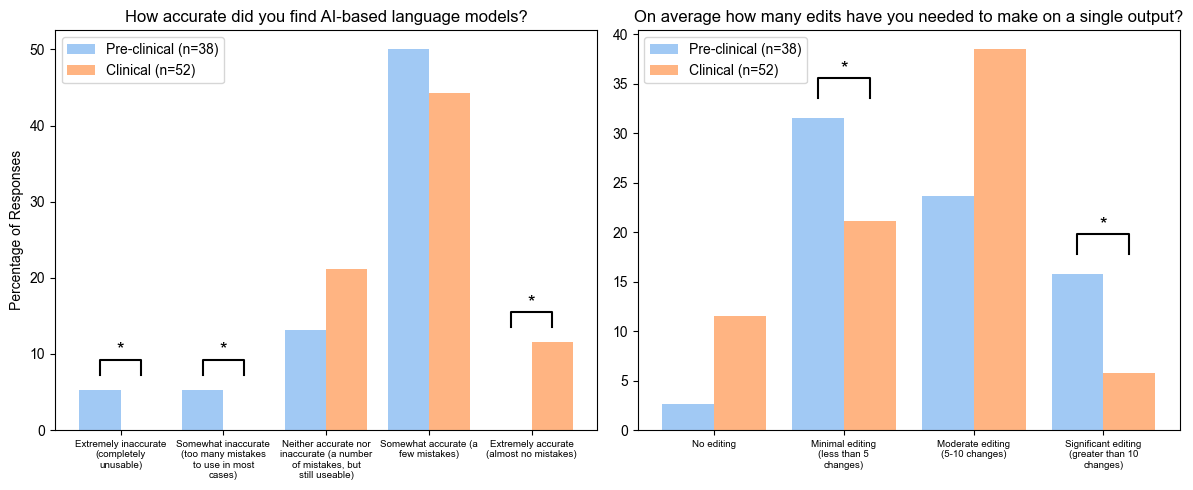

In [32]:
# Plot LLM Accuracy + Editing Perspectives
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("pastel") # color palette

preclin_acc = merged_LLM_accuracy["Pre-clinical"]
clin_acc = merged_LLM_accuracy["Clinical"]

# Plot Accuracy (1st subplot)
bar_width = 0.4
x = np.arange(len(merged_LLM_accuracy["Response"]))
ax[0].bar(x - bar_width / 2, preclin_acc, width=bar_width, label="Pre-clinical (n=38)")
ax[0].bar(x + bar_width / 2, clin_acc, width=bar_width, label="Clinical (n=52)")

ax[0].set_ylabel("Percentage of Responses")
ax[0].set_title("How accurate did you find AI-based language models?")
acc_labels = merged_LLM_accuracy["Response"]
ax[0].set_xticks(x, [textwrap.fill(label, 20) for label in acc_labels], fontsize = 7)
ax[0].legend()

# Add significance bars
for i, pvalue in enumerate(accuracy_p_value_df['pvalue']):
    if pvalue < alpha_adjusted:
        # Coordinates for the significance bar
        x1, x2 = x[i] - bar_width / 2, x[i] + bar_width / 2
        y_max = max(preclin.iloc[i], clin.iloc[i])
        y, h, col = y_max + 2, 2, 'black'
        ax[0].plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax[0].text((x1 + x2) / 2, y + h, '*', ha='center', va='bottom', color=col, fontsize=14)


# Plot Editing (2nd subplot)
bar_width = 0.4
x_e = np.arange(len(merged_LLM_edit["Response"]))

preclin_edit = merged_LLM_edit["Pre-clinical"]
clin_edit = merged_LLM_edit["Clinical"]

ax[1].bar(x_e - bar_width / 2, preclin_edit, width=bar_width, label="Pre-clinical (n=38)")
ax[1].bar(x_e + bar_width / 2, clin_edit, width=bar_width, label="Clinical (n=52)")

ax[1].set_title("On average how many edits have you needed to make on a single output?")
edit_labels = merged_LLM_edit["Response"]
ax[1].set_xticks(x_e, [textwrap.fill(label, 20) for label in edit_labels], fontsize = 7)
ax[1].legend()

# Add significance bars
for i, pvalue in enumerate(edit_p_value_df['pvalue']):
    if pvalue < alpha_adjusted:
        # Coordinates for the significance bar
        x1, x2 = x_e[i] - bar_width / 2, x_e[i] + bar_width / 2
        y_max = max(preclin_edit.iloc[i], clin_edit.iloc[i])
        y, h, col = y_max + 2, 2, 'black'
        ax[1].plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax[1].text((x1 + x2) / 2, y + h, '*', ha='center', va='bottom', color=col, fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()